# Development Sites within Cambridge, UK

Cambridge, Uk is an economically expanding City within England. Job oppertunitys for young professionals are increasing at a high rate within the area. Real estate developers are looking to build new properties to cater to the needs on this wave of young working professionals. To determine which areas are the most desirable for this group to move into the developers must consider many factors for each area, including; Close proximity to Bars, Restaurants and pubs, lowest crime rates and closets proximity to the cities Train stations.

To help understand these factos we must first begin gathering data from multiple sources

The geospacial data for each area is avalible from the goverrment repository and will help us break up the city into defined districts (postal codes).

The crime statistics for each area are provided monthly by the local police forces, we will take the data provided for the last 6 months, merge the files and clean them to provide information on total crimes within each area and visulise them on the maps.

We will then use foursquared to gather information on local venues, as more high quality local attractions will be more desirable for potential property investors.

The informtion provided from each of these will be combined to provde a toltal overview for each area that will also us to help the real estate companies investers determine which areas are the most suitable to build properties that would appeal to the chosen demongraphic.


## Contents of Notebook:

### Broardly this Project can be broken down into the main sections of analysis: 
### 1) Candidate locations and proximity to train stations. 
### 2) Crime statistics and relationships to Candidate Areas. 
### 3) Local Venues by Area

#### Expanding these sections we have the following subsections:

1- Libraries to be imported

2- Candidate city

3- Candidate Areas

4- Location of Train Stations

5- Distances to Train Stations

6- Crime data

7- Visulisation of crimes within Cambridge

8- Local Venues

9- Clustering Local Venues

10- Visulisation of Local Venues on Interactive Map

11- Venue Sub-groups

### Each section of analysis is broken down into and follows the subsections of: Data Collection, Data Formatting and Cleaning, Data Analysis, Visulisation and Interpretation.

In [107]:
# Firstly we will install geopy and folium - these may take a while 
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [108]:
# We import all the libraries required for the data analysis
import requests
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import folium
from bs4 import BeautifulSoup
import requests
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Image
from IPython.core.display import HTML
from geopy.geocoders import Nominatim
from geopy.distance import distance
from folium.plugins import HeatMap
print("All libraries imported")


All libraries imported


## Candidate City

In [109]:
# Firstly, lets determine the latitude and longtitude for Cambridge, UK and visulise it for the investers that are unfamiliar with its location
CLIENT_ID = 'KQAXVT22LMEYG2SWTR5OOLLWKXXYYIEYY55AHCODRNY3CHBB'
CLIENT_SECRET = 'URAV3RDJKJMBI45AEYF2JF4GMHCWT1KYT2EOUU0ZIIKZVHYM'
VERSION = '20200101'
LIMIT = 30
print("Loaded CLIENT ID AND CLIENT SECRET to connect to FourSquare API")

Loaded CLIENT ID AND CLIENT SECRET to connect to FourSquare API


In [171]:
# Lets find our City center point and determine its exact location
address = 'Guildhall Place, Cambridge, England'

geolocator = Nominatim(user_agent="Foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The co-ordinates for a central point in cambridge are: ", latitude, longitude)


The co-ordinates for a central point in cambridge are:  52.204637 0.1199107


In [172]:
# Lets visulise this City for those unfamiliar with the region/country
Cam_map = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Marker([latitude, longitude], popup="Cambridge").add_to(Cam_map)
folium.Circle([latitude, longitude], radius=4400, color='blue', fill=False).add_to(Cam_map)
 
print("If you zoom out on the map you can see the close proximity of Cambridge to London, this enables many to communte back and fourth. This is why a closer proximity to one of Cambridges train stations is desireable")
Cam_map

If you zoom out on the map you can see the close proximity of Cambridge to London, this enables many to communte back and fourth. This is why a closer proximity to one of Cambridges train stations is desireable


## Areas within Cambridge

#### Now we know where Cambridge is located in the UK. Lets break the City down into districts based on the postcodes and then break it down further into our 'Areas'

In [113]:
# We will first take the locations of every single postcode, downloaded and provided by the website Free Map Tools and collected and Stored by the Royal Mail Postal service
PostCodes_df = pd.read_csv("ukpostcodes.csv")

In [114]:
# If you view this dataframe in full you will see it contains 1766510 postcode locations all in the form...
PostCodes_df.head()

id  postcode   latitude  longitude
0   1  AB10 1XG  57.144165  -2.114848
1   2  AB10 6RN  57.137880  -2.121487
2   3  AB10 7JB  57.124274  -2.127190
3   4  AB11 5QN  57.142701  -2.093295
4   5  AB11 6UL  57.137547  -2.112233

In [115]:
PostCodes_df.shape

(1766510, 4)

In [116]:
# We need to reduce this dataframe to one that contains only the information on Postcodes begining with CB, which corresponds to the Cambridge area (its contained within a column called postcode)

In [117]:
PC_Cam_df= PostCodes_df[PostCodes_df["postcode"].str.startswith('CB', na=False)]
PC_Cam_df.head()

id postcode   latitude  longitude
1390037  1482225  CB9 9BT  52.083135   0.423049
1390038  1482226  CB9 9BU  52.082872   0.422232
1390039  1482227  CB9 9BW  52.084244   0.424583
1390040  1482228  CB9 9BX  52.082824   0.423092
1390041  1482229  CB9 9BY  52.082157   0.422894

In [118]:
PC_Cam_df.shape

(10455, 4)

In [119]:
# Lets remove all the columns we dont want anymore
PC_Cam_df2=PC_Cam_df[['postcode', 'latitude','longitude']]
PC_Cam_df2.head()

postcode   latitude  longitude
1390037  CB9 9BT  52.083135   0.423049
1390038  CB9 9BU  52.082872   0.422232
1390039  CB9 9BW  52.084244   0.424583
1390040  CB9 9BX  52.082824   0.423092
1390041  CB9 9BY  52.082157   0.422894

In [120]:
# This still contains over 10455 values, we want to cluster these into the 16 CB#, 3 digit postcodes used by the english postal service and widly recognised within the country

In [121]:
PC_Cam_df2['postcode'] = PC_Cam_df2['postcode'].str.replace(" ", "")
PC_Cam_df2['postcode'] = PC_Cam_df2['postcode'].str[:-3]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [122]:
PC_Cam_df2.head()

postcode   latitude  longitude
1390037      CB9  52.083135   0.423049
1390038      CB9  52.082872   0.422232
1390039      CB9  52.084244   0.424583
1390040      CB9  52.082824   0.423092
1390041      CB9  52.082157   0.422894

In [124]:
PC_Cam_df3 = PC_Cam_df2.groupby('postcode', as_index=False).mean()

In [125]:
PC_Cam_df3.shape

(16, 3)

In [126]:
# Lets have a look at our clustered Postcodes
PC_Cam_df3.head(17)


postcode   latitude  longitude
0       CB1  52.195456   0.142192
1      CB10  52.028721   0.262982
2      CB11  51.999055   0.212503
3       CB2  52.186007   0.123170
4      CB21  52.127987   0.281419
5      CB22  52.128300   0.135502
6      CB23  52.215592  -0.032832
7      CB24  52.277158   0.084288
8      CB25  52.260817   0.253450
9       CB3  52.211773   0.098918
10      CB4  52.222933   0.129807
11      CB5  52.212400   0.153758
12      CB6  52.404652   0.221754
13      CB7  52.362636   0.323353
14      CB8  52.229860   0.427659
15      CB9  52.083298   0.439739

In [174]:
# Now we have the average Latitude and Longitude for each postcode, lets have a look at them on the map
Cam_map2 = folium.Map(location=[latitude, longitude], zoom_start=9)

for latitude, longitude, postcode in zip(PC_Cam_df3['latitude'], PC_Cam_df3['longitude'], PC_Cam_df3['postcode']): 
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        color='blue',
        popup=postcode,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Cam_map2)
    
Cam_map2

As you can see, some of the postcodes are areas very far from the City center, given the developers want properties for individuals who like ammusements and ammenities, we will select only the 5 postcodes closest to our assigned central point (CB1, CB2, CB3, CB4 and CB5).

In [128]:
PC_Cam_df4 = PC_Cam_df3.loc[PC_Cam_df3['postcode'].isin(['CB1','CB2','CB3','CB4','CB5'])]
PC_Cam_df4.head()


postcode   latitude  longitude
0       CB1  52.195456   0.142192
3       CB2  52.186007   0.123170
9       CB3  52.211773   0.098918
10      CB4  52.222933   0.129807
11      CB5  52.212400   0.153758

Before we map the 5 selected postcodes, let us first locate the train stations within Cambridge so we can see where they are within the city.

In [129]:
# Train station 1 - Central Station
Cam_train_1_address = 'Central Station'

Train_1_latitude = 52.194292
Train_1_longitude = 0.137179
print("The co-ordinates for a central train station in cambridge are: ", Train_1_latitude, Train_1_longitude)

The co-ordinates for a central train station in cambridge are:  52.194292 0.137179


In [130]:
# Train station 2 - Cambridge North
Cam_train_2_address = 'Cambridge North'

Train_2_latitude = 52.224268
Train_2_longitude = 0.157685
print("The co-ordinates for a central point in cambridge are: ", Train_2_latitude, Train_2_longitude)

The co-ordinates for a central point in cambridge are:  52.224268 0.157685


In [131]:
Cam_map3 = folium.Map(location=[latitude, longitude], zoom_start=12)

for latitude, longitude, postcode in zip(PC_Cam_df4['latitude'], PC_Cam_df4['longitude'], PC_Cam_df4['postcode']): 
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=postcode,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Cam_map3)
    folium.CircleMarker([Train_1_latitude, Train_1_longitude],
        radius=4,
        popup='Central Station',
        color='red',
        fill=True,
        fill_color='#3186cc').add_to(Cam_map3)
    folium.CircleMarker([Train_2_latitude, Train_2_longitude],
        radius=4,
        popup='Cambridge North Station',
        color='red',
        fill=True,
        fill_color='#3186cc').add_to(Cam_map3)
    

Cam_map3

As we can see from the map, CB1 is  closest to Central train station and by far the closest to any station on the map of any of the areas. CB4 and CB5 are the closest to Cambridge North station and CB3 is far from both stations.

In [132]:
# Lets add colums that tell us how far exactly each area is form the two stations
stations = {'Station': [Cam_train_1_address, Cam_train_2_address], 'Station_Latitude': [Train_1_latitude, Train_2_latitude], 'Station_Longitude': [Train_1_longitude, Train_2_longitude]}
Cam_stations = pd.DataFrame(stations)
Cam_stations.head()

Station  Station_Latitude  Station_Longitude
0  Central Station         52.194292           0.137179
1  Cambridge North         52.224268           0.157685

In [133]:
# To work out the distance we need to use the geopy function distance and each of our points must be recorded
Cen_sta = (52.194292, 0.137179)
Cam_nor = (52.224268, 0.157685)
CB1 = (52.195456, 0.142192)
CB2 = (52.186007, 0.123170)
CB3 = (52.211773, 0.098918)
CB4 = (52.222933, 0.129807)
CB5 = (52.212400, 0.153758)

CB1_cen = distance(CB1, Cen_sta).km
CB1_cam = distance(CB1, Cam_nor).km
CB2_cen = distance(CB2, Cen_sta).km
CB2_cam = distance(CB2, Cam_nor).km
CB3_cen = distance(CB3, Cen_sta).km
CB3_cam = distance(CB3, Cam_nor).km
CB4_cen = distance(CB4, Cen_sta).km
CB4_cam = distance(CB4, Cam_nor).km
CB5_cen = distance(CB5, Cen_sta).km
CB5_cam = distance(CB5, Cam_nor).km

PC_stat_dist = {'postcode': ['CB1','CB2','CB3','CB4','CB5'], 'Distance_to_Central_km': [CB1_cen, CB2_cen,CB3_cen,CB4_cen,CB5_cen], 'Distance_to_Cam_North_km': [CB1_cam,CB2_cam,CB3_cam,CB4_cam,CB5_cam]}
PC_dist_station_df = pd.DataFrame(PC_stat_dist)
PC_dist_station_df.head()

postcode  Distance_to_Central_km  Distance_to_Cam_North_km
0      CB1                0.366439                  3.376343
1      CB2                1.329542                  4.867504
2      CB3                3.259735                  4.250203
3      CB4                3.226519                  1.910835
4      CB5                2.311822                  1.347567

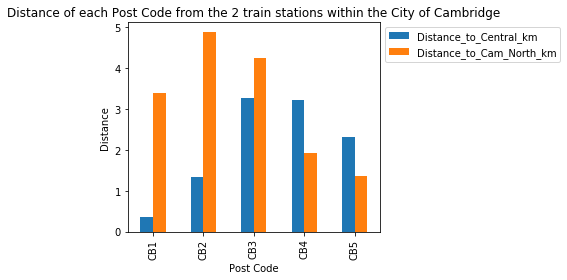

In [134]:
PC_dist_station_df.plot(x='postcode', y=['Distance_to_Central_km','Distance_to_Cam_North_km'], kind='bar')
plt.ylabel('Distance')
plt.xlabel('Post Code')
plt.title("Distance of each Post Code from the 2 train stations within the City of Cambridge")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))

From the graph we can see that CB1 is extremly close to the central station, as is CB2, but both are far from Cambridge North station. CB4 and CB5 are closer to Cambridge north but still not too far from Central station.

## Crimes within each area

Crime statistics don't provide named locations that transfers to our defined areas, however, each crime does contain and exact Latitude and Longitude, allowing us to visulise them on the map.

First we must import the 6 files corresponding to the crimes reported for each month and merge them into one dataframe, we must then remove all the crimes that happened outside the Cambridge areas (The city of Cambridge is located within the district of Cambridgeshire which contains differnet towns etc). We will then remove all the crimes with missing location data, as well as some more minor offences such as shoplifting.

In [135]:
Cstat1 = pd.read_csv('2019-09-cambridgeshire-street.csv')
print("The shape of the 6 dataframes are: ")
print(Cstat1.shape)
Cstat2 = pd.read_csv('2019-10-cambridgeshire-street.csv')
print(Cstat2.shape)
Cstat3 = pd.read_csv('2019-11-cambridgeshire-street.csv')
print(Cstat3.shape)
Cstat4 = pd.read_csv('2019-12-cambridgeshire-street.csv')
print(Cstat4.shape)
Cstat5 = pd.read_csv('2020-01-cambridgeshire-street.csv')
print(Cstat5.shape)
Cstat6 = pd.read_csv('2020-02-cambridgeshire-street.csv')
print(Cstat6.shape)
Crime_stat= pd.concat([Cstat1,Cstat2,Cstat3,Cstat4,Cstat5,Cstat6], ignore_index=True)
Crime_stat.to_csv('Cambridge_Crimes_6months.csv')
print("The shape of the merged dataframe is: ")
print(Crime_stat.shape)
# We will then keep only the relevent columns; longitude, latitudes, LSOA location, LSOA name and crime type and remove all entiries without a location.
Crime_stat1 = Crime_stat.filter(["Longitude", "Latitude", "LSOA code", "LSOA name", "Crime type"], axis=1)
#Filter out crimes that didn't happen in Cambridge City
Crime_stat2= Crime_stat1[Crime_stat1["LSOA name"].str.startswith('Cambridge', na=False)]
Crime_stat3= Crime_stat2.drop_duplicates()
Crime_stat4 = Crime_stat3.rename(columns = {"Crime type" : "CrimeType"})
Crime_stat4.dropna(inplace=True)
print("Shape of Dataframe without duplicates or irrelivent columns")
print(Crime_stat4.shape)


print("6 Files loaded and Merged and redundant colums and data removed")

The shape of the 6 dataframes are: 
(7238, 12)
(7115, 12)
(6995, 12)
(6589, 12)
(6987, 12)
(6625, 12)
The shape of the merged dataframe is: 
(41549, 12)
Shape of Dataframe without duplicates or irrelivent columns
(3686, 5)
6 Files loaded and Merged and redundant colums and data removed


In [136]:
Crime_stat4.head()

Longitude   Latitude  LSOA code       LSOA name                  CrimeType
4   0.135772  52.232788  E01017975  Cambridge 001A      Anti-social behaviour
5   0.133320  52.228984  E01017975  Cambridge 001A      Anti-social behaviour
6   0.136532  52.228485  E01017975  Cambridge 001A  Criminal damage and arson
7   0.131681  52.229005  E01017975  Cambridge 001A  Criminal damage and arson
8   0.133320  52.228984  E01017975  Cambridge 001A  Criminal damage and arson

##### Lets Plot all these crimes so that we can start to understand the distribution of crimes across our City, and in relation to our Areas

In [137]:

Cam_crime = folium.Map(location=[latitude, longitude], zoom_start=12)

for Latitude, Longitude, CrimeType in zip(Crime_stat4['Latitude'], Crime_stat4['Longitude'], Crime_stat4['CrimeType']):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=1,
        popup=CrimeType,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Cam_crime)
    
for latitude, longitude, postcode in zip(PC_Cam_df4['latitude'], PC_Cam_df4['longitude'], PC_Cam_df4['postcode']): 
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        color='blue',
        popup=postcode,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Cam_crime)
    
       
Cam_crime

In [177]:
# Lets create a heatmap to visulise the crime data a little more in depth
Crim_heat = HeatMap(list(zip(Crime_stat4.Latitude.values, Crime_stat4.Longitude.values)),
                     min_opacity=0.1,
                     radius=5, blur=8,
                     max_zoom=1)
Cam_crime_heat.add_child(Cam_map3)
Cam_map3

As can be seen from the heatmap, areas CB3 and CB2 are much less densly packed with reported crimes, where as CB1, CB4 and CB5 display much brighter areas

## Restaurants within our areas

In [139]:
# Lets use the Foursquare API to provide informtion on the 250 Venues within the City of Cambridge and see where they are on the map.

In [140]:
## Using example from Coursera notebook load all the venues within our designated area
# I will increase the limit here to allow us to pick up more venues
LIMIT1 = 100 #This should pick up 100 venues

In [141]:
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT1)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [142]:
Cam_venu_df = getNearbyVenues(names=PC_Cam_df4['postcode'],
                                   latitudes=PC_Cam_df4['latitude'],
                                   longitudes=PC_Cam_df4['longitude']
                                  )
Cam_venu_df.head()

CB1
CB2
CB3
CB4
CB5


Area  Area Latitude  Area Longitude                                 Venue  \
0  CB1      52.195456        0.142192                           Hot Numbers   
1  CB1      52.195456        0.142192                   Calverley's Brewery   
2  CB1      52.195456        0.142192                            Tradizioni   
3  CB1      52.195456        0.142192                       The Petersfield   
4  CB1      52.195456        0.142192  Cambridge University Botanic Gardens   

   Venue Latitude  Venue Longitude      Venue Category  
0       52.200038         0.138520                Café  
1       52.201304         0.142541             Brewery  
2       52.197918         0.143936  Italian Restaurant  
3       52.201280         0.140648           Gastropub  
4       52.194013         0.128072    Botanical Garden

In [143]:
Cam_venu_df.shape

(500, 7)

In [144]:
# Lets visulise 100 venues on our map of the City
Cam_Venues = folium.Map(location=[latitude, longitude], zoom_start=12)

for latitude, longitude, Venue in zip(Cam_venu_df['Venue Latitude'], Cam_venu_df['Venue Longitude'], Cam_venu_df['Venue Category']):
    folium.CircleMarker(
        [latitude, longitude],
        radius=2,
        color='Red',
        popup=Venue,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Cam_Venues)
    
for latitude, longitude, postcode in zip(PC_Cam_df4['latitude'], PC_Cam_df4['longitude'], PC_Cam_df4['postcode']): 
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        color='blue',
        popup=postcode,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Cam_Venues)
    
       
Cam_Venues

Lets start to see which venues are in each area

In [145]:
Cam_venu_df.head()

Area  Area Latitude  Area Longitude                                 Venue  \
0  CB1      52.195456        0.142192                           Hot Numbers   
1  CB1      52.195456        0.142192                   Calverley's Brewery   
2  CB1      52.195456        0.142192                            Tradizioni   
3  CB1      52.195456        0.142192                       The Petersfield   
4  CB1      52.195456        0.142192  Cambridge University Botanic Gardens   

   Venue Latitude  Venue Longitude      Venue Category  
0       52.200038         0.138520                Café  
1       52.201304         0.142541             Brewery  
2       52.197918         0.143936  Italian Restaurant  
3       52.201280         0.140648           Gastropub  
4       52.194013         0.128072    Botanical Garden

In [146]:
Cam_venu_df.shape

(500, 7)

In [147]:
Cam_venu_df.groupby('Area').count()

Area Latitude  Area Longitude  Venue  Venue Latitude  Venue Longitude  \
Area                                                                          
CB1             100             100    100             100              100   
CB2             100             100    100             100              100   
CB3             100             100    100             100              100   
CB4             100             100    100             100              100   
CB5             100             100    100             100              100   

      Venue Category  
Area                  
CB1              100  
CB2              100  
CB3              100  
CB4              100  
CB5              100

Lets now use one hot encoding to allow us to cluster are areas using kmeans clustering

In [204]:
Cam_onehot = pd.get_dummies(Cam_venu_df[['Venue Category']], prefix="", prefix_sep="")

Cam_onehot.insert(loc=0, column='Area', value=Cam_venu_df['Area'] )
Cam_onehot.shape

(500, 58)

In [205]:
# Here we have the venue types but we need to merge the Areas into our 5 known areas to work out how many of each venue type in each area...
Cam_onehot.head()

Area  American Restaurant  Art Gallery  Asian Restaurant  Bakery  Bar  \
0  CB1                    0            0                 0       0    0   
1  CB1                    0            0                 0       0    0   
2  CB1                    0            0                 0       0    0   
3  CB1                    0            0                 0       0    0   
4  CB1                    0            0                 0       0    0   

   Bed & Breakfast  Beer Garden  Bookstore  Botanical Garden    ...      \
0                0            0          0                 0    ...       
1                0            0          0                 0    ...       
2                0            0          0                 0    ...       
3                0            0          0                 0    ...       
4                0            0          0                 1    ...       

   Sandwich Place  Scenic Lookout  Science Museum  Soccer Stadium  Steakhouse  \
0               0               0               0               0           0   
1               0               0               0               0           0   
2               0               0               0               0           0   
3               0               0               0               0           0   
4               0               0               0               0           0   

   Supermarket  Thai Restaurant  Theater  Train Station  Wine Shop  
0            0                0        0              0          0  
1            0                0        0              0          0  
2            0                0        0              0          0  
3            0                0        0              0          0  
4            0                0        0              0          0  

[5 rows x 58 columns]

In [234]:
Cam_grouped = Cam_onehot.groupby('Area', as_index=False).mean()
Cam_grouped.head()

Area  American Restaurant  Art Gallery  Asian Restaurant  Bakery   Bar  \
0  CB1                 0.01         0.01              0.00    0.02  0.01   
1  CB2                 0.01         0.01              0.01    0.02  0.01   
2  CB3                 0.00         0.01              0.00    0.02  0.01   
3  CB4                 0.00         0.01              0.00    0.02  0.02   
4  CB5                 0.01         0.01              0.00    0.02  0.01   

   Bed & Breakfast  Beer Garden  Bookstore  Botanical Garden    ...      \
0             0.00         0.01       0.02              0.01    ...       
1             0.00         0.01       0.02              0.01    ...       
2             0.01         0.01       0.02              0.01    ...       
3             0.00         0.02       0.02              0.01    ...       
4             0.00         0.01       0.02              0.01    ...       

   Sandwich Place  Scenic Lookout  Science Museum  Soccer Stadium  Steakhouse  \
0            0.01            0.00            0.01            0.00        0.01   
1            0.01            0.00            0.01            0.00        0.01   
2            0.01            0.00            0.01            0.00        0.00   
3            0.01            0.01            0.01            0.01        0.00   
4            0.01            0.01            0.01            0.01        0.00   

   Supermarket  Thai Restaurant  Theater  Train Station  Wine Shop  
0         0.03             0.02     0.01           0.00       0.02  
1         0.03             0.02     0.01           0.00       0.02  
2         0.03             0.02     0.01           0.00       0.01  
3         0.02             0.02     0.01           0.01       0.02  
4         0.02             0.02     0.01           0.01       0.02  

[5 rows x 58 columns]

In [235]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [236]:
#Take 25 top venues to analyse
num_top_venues = 25

indicators = ['st', 'nd', 'rd']

# create columns for number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Areas_venues_sorted = pd.DataFrame(columns=columns)
Areas_venues_sorted['Area'] = Cam_grouped['Area']

for ind in np.arange(Cam_grouped.shape[0]):
    Areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Cam_grouped.iloc[ind, :], num_top_venues)

Areas_venues_sorted.head()


Area 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0  CB1                  Café                   Pub           Coffee Shop   
1  CB2                  Café           Coffee Shop                   Pub   
2  CB3                  Café                   Pub           Coffee Shop   
3  CB4                   Pub           Coffee Shop                  Café   
4  CB5                   Pub                  Café           Coffee Shop   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0          Burger Joint             Gastropub         Grocery Store   
1             Gastropub          Burger Joint            Restaurant   
2         Grocery Store             Gastropub          Burger Joint   
3                 Hotel         Grocery Store          Burger Joint   
4          Burger Joint         Grocery Store  Gym / Fitness Center   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Restaurant     Indian Restaurant                  Park   
1  Gym / Fitness Center     Indian Restaurant                  Park   
2                 Hotel           Supermarket                  Park   
3     Indian Restaurant             Gastropub                  Park   
4             Gastropub                 Hotel     Indian Restaurant   

           ...           16th Most Common Venue 17th Most Common Venue  \
0          ...               Chinese Restaurant              Wine Shop   
1          ...                    Deli / Bodega     Chinese Restaurant   
2          ...                        Bookstore                 Bakery   
3          ...                        Bookstore            Beer Garden   
4          ...                        Bookstore                 Bakery   

  18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  \
0  Portuguese Restaurant              Bookstore                    Bar   
1              Bookstore  Portuguese Restaurant              Wine Shop   
2        Thai Restaurant   Gym / Fitness Center          Garden Center   
3                    Bar                 Bakery            Supermarket   
4            Supermarket        Thai Restaurant                Brewery   

  21th Most Common Venue 22th Most Common Venue 23th Most Common Venue  \
0            Beer Garden         Clothing Store                Brewery   
1       Asian Restaurant                    Bar         Clothing Store   
2     English Restaurant                  Field              Wine Shop   
3        Thai Restaurant                Brewery       Botanical Garden   
4         Breakfast Spot       Botanical Garden            Beer Garden   

  24th Most Common Venue 25th Most Common Venue  
0                 Buffet     English Restaurant  
1       Botanical Garden                 Buffet  
2         Clothing Store                Brewery  
3         Clothing Store          Deli / Bodega  
4         Clothing Store                    Bar  

[5 rows x 26 columns]

In [237]:
kclusters = 4

Cam_grouped_clust = Cam_grouped.drop('Area', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Cam_grouped_clust)

kmeans.labels_[0:10]

array([2, 2, 1, 3, 0], dtype=int32)

In [238]:
# add clustering labels and merge Cam_grouped with PC_Cam_df4 to add latitude/longitude for each neighborhood
# First we just need to rename the columns for our Area details dataframe (PC_Cam_df4) so that they match the venue dataframes to allow us to merge the two
PC_Cam_df4.rename(columns={'postcode':'Area'})
Areas_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

Cam_merged = PC_Cam_df4

Cam_merged = Cam_merged.join(Areas_venues_sorted.set_index('Area'), on='postcode')

Cam_merged.head()

postcode   latitude  longitude  ClusterLabels 1st Most Common Venue  \
0       CB1  52.195456   0.142192              2                  Café   
3       CB2  52.186007   0.123170              2                  Café   
9       CB3  52.211773   0.098918              1                  Café   
10      CB4  52.222933   0.129807              3                   Pub   
11      CB5  52.212400   0.153758              0                   Pub   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                    Pub           Coffee Shop          Burger Joint   
3            Coffee Shop                   Pub             Gastropub   
9                    Pub           Coffee Shop         Grocery Store   
10           Coffee Shop                  Café                 Hotel   
11                  Café           Coffee Shop          Burger Joint   

   5th Most Common Venue 6th Most Common Venue          ...            \
0              Gastropub         Grocery Store          ...             
3           Burger Joint            Restaurant          ...             
9              Gastropub          Burger Joint          ...             
10         Grocery Store          Burger Joint          ...             
11         Grocery Store  Gym / Fitness Center          ...             

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0      Chinese Restaurant              Wine Shop  Portuguese Restaurant   
3           Deli / Bodega     Chinese Restaurant              Bookstore   
9               Bookstore                 Bakery        Thai Restaurant   
10              Bookstore            Beer Garden                    Bar   
11              Bookstore                 Bakery            Supermarket   

   19th Most Common Venue 20th Most Common Venue 21th Most Common Venue  \
0               Bookstore                    Bar            Beer Garden   
3   Portuguese Restaurant              Wine Shop       Asian Restaurant   
9    Gym / Fitness Center          Garden Center     English Restaurant   
10                 Bakery            Supermarket        Thai Restaurant   
11        Thai Restaurant                Brewery         Breakfast Spot   

   22th Most Common Venue 23th Most Common Venue 24th Most Common Venue  \
0          Clothing Store                Brewery                 Buffet   
3                     Bar         Clothing Store       Botanical Garden   
9                   Field              Wine Shop         Clothing Store   
10                Brewery       Botanical Garden         Clothing Store   
11       Botanical Garden            Beer Garden         Clothing Store   

   25th Most Common Venue  
0      English Restaurant  
3                  Buffet  
9                 Brewery  
10          Deli / Bodega  
11                    Bar  

[5 rows x 29 columns]

In [239]:
Cam_merged.dtypes

postcode                   object
latitude                  float64
longitude                 float64
ClusterLabels               int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
11th Most Common Venue     object
12th Most Common Venue     object
13th Most Common Venue     object
14th Most Common Venue     object
15th Most Common Venue     object
16th Most Common Venue     object
17th Most Common Venue     object
18th Most Common Venue     object
19th Most Common Venue     object
20th Most Common Venue     object
21th Most Common Venue     object
22th Most Common Venue     object
23th Most Common Venue     object
24th Most Common Venue     object
25th Most Common Venue     object
dtype: object

In [243]:
# Now lets visulise our clusters
Cam_Venues_Clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for latitude, longitude, postcode, poi in zip(Cam_merged['latitude'], Cam_merged['longitude'],Cam_merged['postcode'], Cam_merged['ClusterLabels']):
    label = folium.Popup(str() + ' Cluster ' + str(kclusters), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[kclusters-1],
        fill=True,
        fill_color=rainbow[kclusters-1],
        fill_opacity=0.7).add_to(Cam_Venues_Clusters)
Cam_Venues_Clusters

In [156]:
# Our clusters are our Areas or Postcodes.

### Lets look at which venues are within each area and visulse this information for developers to see which types of venues are within the potential development areas.

In [157]:
# lets take our grouped venues data and see what the venue types are
# NOTE that because this is a small area, and we specified our limit at 100 closest venues, some of the venues may be counted in multiple areas
Cam_grouped.head()

Area  American Restaurant  Art Gallery  Asian Restaurant  Bakery   Bar  \
0  CB1                 0.01         0.01              0.00    0.02  0.01   
1  CB2                 0.01         0.01              0.01    0.02  0.01   
2  CB3                 0.00         0.01              0.00    0.02  0.01   
3  CB4                 0.00         0.01              0.00    0.02  0.02   
4  CB5                 0.01         0.01              0.00    0.02  0.01   

   Bed & Breakfast  Beer Garden  Bookstore  Botanical Garden    ...      \
0             0.00         0.01       0.02              0.01    ...       
1             0.00         0.01       0.02              0.01    ...       
2             0.01         0.01       0.02              0.01    ...       
3             0.00         0.02       0.02              0.01    ...       
4             0.00         0.01       0.02              0.01    ...       

   Sandwich Place  Scenic Lookout  Science Museum  Soccer Stadium  Steakhouse  \
0            0.01            0.00            0.01            0.00        0.01   
1            0.01            0.00            0.01            0.00        0.01   
2            0.01            0.00            0.01            0.00        0.00   
3            0.01            0.01            0.01            0.01        0.00   
4            0.01            0.01            0.01            0.01        0.00   

   Supermarket  Thai Restaurant  Theater  Train Station  Wine Shop  
0         0.03             0.02     0.01           0.00       0.02  
1         0.03             0.02     0.01           0.00       0.02  
2         0.03             0.02     0.01           0.00       0.01  
3         0.02             0.02     0.01           0.01       0.02  
4         0.02             0.02     0.01           0.01       0.02  

[5 rows x 58 columns]

As you can see there are 58 differnt venue types. This structure wouldn't be very helpful if we were to visulise it graphically so we will group these differnt variables into sub categories to allow for better analysis.

First lets get a list of all the categories:

In [158]:
for col_name in Cam_grouped.columns:
    print(col_name)

Area
American Restaurant
Art Gallery
Asian Restaurant
Bakery
Bar
Bed & Breakfast
Beer Garden
Bookstore
Botanical Garden
Breakfast Spot
Brewery
Buffet
Burger Joint
Café
Chinese Restaurant
Clothing Store
Coffee Shop
Deli / Bodega
English Restaurant
Field
Fish & Chips Shop
Food & Drink Shop
Furniture / Home Store
Garden Center
Gastropub
Grocery Store
Gym
Gym / Fitness Center
Gym Pool
History Museum
Hotel
Ice Cream Shop
Indian Restaurant
Indie Movie Theater
Italian Restaurant
Lounge
Market
Multiplex
Office
Park
Performing Arts Venue
Pharmacy
Pizza Place
Portuguese Restaurant
Pub
Record Shop
Restaurant
Sandwich Place
Scenic Lookout
Science Museum
Soccer Stadium
Steakhouse
Supermarket
Thai Restaurant
Theater
Train Station
Wine Shop


Lets groups these into:

Restaurants: American Restaurant, Asian Restaurant, Buffet, Burger Joint, Chinese Restaurant, English Restaurant, Fish & Chips Shop, Gastropub, Indian Restaurant, Italian Restaurant, Pizza Place, Portuguese Restaurant, Restaurant, Steakhouse and Thai Restaurant

Bars/Pubs: Bar, Beer Garden, Brewery and Pub

Cafe: Bakery, Breakfast Spot, Café, Coffee Shop, Deli / Bodega, Ice Cream Shop, Lounge and Sandwich Place

Recreation: Botanical Garden, Field, Gym, Gym / Fitness Center, Gym Pool, Park, Scenic Lookout and Soccer Stadium

Arts: Art Gallery, History Museum, Indie Movie Theater, Performing Arts Venue, Science Museum and Theater

Shops: Bookstore, Clothing Store, Food & Drink Shop, Furniture / Home Store, Garden Center, Grocery Store, Market, Pharmacy, Record Shop, Supermarket and Wine Shop


Other: Bed & Breakfast, Hotel, Multiplex, Office and Train Station

In [159]:
# Lets cluster together the columns based on the Venue types and have a look and the tally
Cam_grouped["Restaurants"] = Cam_grouped['American Restaurant'] + Cam_grouped['Asian Restaurant']+ Cam_grouped['Buffet']+ Cam_grouped['Burger Joint']+ Cam_grouped['Chinese Restaurant'] + Cam_grouped['English Restaurant']+ Cam_grouped['Fish & Chips Shop']+ Cam_grouped['Gastropub']+ Cam_grouped['Indian Restaurant']+ Cam_grouped['Italian Restaurant']+ Cam_grouped['Pizza Place']+ Cam_grouped['Portuguese Restaurant'] + Cam_grouped['Restaurant']+ Cam_grouped['Steakhouse'] + Cam_grouped['Thai Restaurant'] 
Cam_grouped["Bars"] = Cam_grouped['Bar'] + Cam_grouped['Beer Garden'] + Cam_grouped['Brewery'] + Cam_grouped['Pub']
Cam_grouped["Cafe"] = Cam_grouped['Bakery'] + Cam_grouped['Breakfast Spot'] + Cam_grouped['Café'] + Cam_grouped['Coffee Shop'] + Cam_grouped['Deli / Bodega']+ Cam_grouped['Ice Cream Shop']+ Cam_grouped['Lounge']+ Cam_grouped['Sandwich Place']
Cam_grouped["Recreation"]=  Cam_grouped['Botanical Garden']+ Cam_grouped['Field']+ Cam_grouped['Gym']+ Cam_grouped['Gym / Fitness Center']+ Cam_grouped['Gym Pool']+ Cam_grouped['Park']+ Cam_grouped['Scenic Lookout']+ Cam_grouped['Soccer Stadium']
Cam_grouped["Arts"]= Cam_grouped['Art Gallery']+ Cam_grouped['History Museum']+ Cam_grouped['Indie Movie Theater']+ Cam_grouped['Performing Arts Venue']+ Cam_grouped['Science Museum']+ Cam_grouped['Theater']
Cam_grouped["Shops"]= Cam_grouped['Bookstore'] + Cam_grouped['Clothing Store'] +Cam_grouped['Food & Drink Shop'] +Cam_grouped['Furniture / Home Store'] +Cam_grouped['Garden Center'] +Cam_grouped['Grocery Store'] +Cam_grouped['Market'] +Cam_grouped['Pharmacy'] +Cam_grouped['Record Shop'] +Cam_grouped['Supermarket'] +Cam_grouped['Wine Shop']
Cam_grouped["Other"]= Cam_grouped['Bed & Breakfast'] +Cam_grouped['Hotel'] +Cam_grouped['Multiplex'] +Cam_grouped['Office'] +Cam_grouped['Train Station']
Cam_grouped.head()

Area  American Restaurant  Art Gallery  Asian Restaurant  Bakery   Bar  \
0  CB1                 0.01         0.01              0.00    0.02  0.01   
1  CB2                 0.01         0.01              0.01    0.02  0.01   
2  CB3                 0.00         0.01              0.00    0.02  0.01   
3  CB4                 0.00         0.01              0.00    0.02  0.02   
4  CB5                 0.01         0.01              0.00    0.02  0.01   

   Bed & Breakfast  Beer Garden  Bookstore  Botanical Garden  ...    Theater  \
0             0.00         0.01       0.02              0.01  ...       0.01   
1             0.00         0.01       0.02              0.01  ...       0.01   
2             0.01         0.01       0.02              0.01  ...       0.01   
3             0.00         0.02       0.02              0.01  ...       0.01   
4             0.00         0.01       0.02              0.01  ...       0.01   

   Train Station  Wine Shop  Restaurants  Bars  Cafe  Recreation  Arts  Shops  \
0           0.00       0.02         0.27  0.13  0.26        0.10  0.06   0.15   
1           0.00       0.02         0.29  0.12  0.26        0.10  0.06   0.14   
2           0.00       0.01         0.22  0.13  0.27        0.10  0.06   0.15   
3           0.01       0.02         0.21  0.18  0.24        0.11  0.06   0.13   
4           0.01       0.02         0.24  0.15  0.24        0.11  0.06   0.15   

   Other  
0   0.03  
1   0.03  
2   0.07  
3   0.07  
4   0.05  

[5 rows x 65 columns]

In [160]:
# Here we create a new Dataframe for just our subgroups. Because the one hot encoding converted the values to decimals, lets convert them back to whole numbers by multiplying by 100
Cam_grouped_df1 = Cam_grouped[['Area','Restaurants', 'Bars','Cafe','Recreation','Arts','Shops','Other']]
Cam_grouped_df1['Restaurants'] = Cam_grouped_df1['Restaurants'].mul(100)
Cam_grouped_df1['Bars'] = Cam_grouped_df1['Bars'].mul(100)
Cam_grouped_df1['Cafe'] = Cam_grouped_df1['Cafe'].mul(100)
Cam_grouped_df1['Recreation'] = Cam_grouped_df1['Recreation'].mul(100)
Cam_grouped_df1['Arts'] = Cam_grouped_df1['Arts'].mul(100)
Cam_grouped_df1['Shops'] = Cam_grouped_df1['Shops'].mul(100)
Cam_grouped_df1['Other'] = Cam_grouped_df1['Other'].mul(100)
Cam_grouped_df1.head()


#This may throw up an error as we are trying to multiply a slice from one of our previous dataframes

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Area  Restaurants  Bars  Cafe  Recreation  Arts  Shops  Other
0  CB1         27.0  13.0  26.0        10.0   6.0   15.0    3.0
1  CB2         29.0  12.0  26.0        10.0   6.0   14.0    3.0
2  CB3         22.0  13.0  27.0        10.0   6.0   15.0    7.0
3  CB4         21.0  18.0  24.0        11.0   6.0   13.0    7.0
4  CB5         24.0  15.0  24.0        11.0   6.0   15.0    5.0

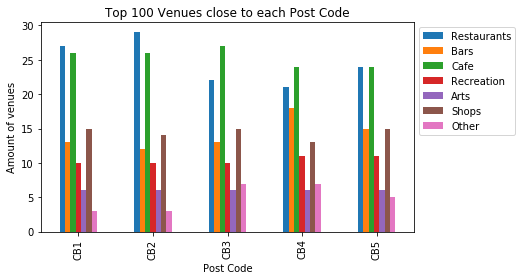

In [178]:
# Lets create a barchart so we can visulise our data
Cam_grouped_df1.plot(x='Area', y=['Restaurants','Bars','Cafe','Recreation','Arts','Shops','Other'], kind='bar')
plt.ylabel('Amount of venues')
plt.xlabel('Post Code')
plt.title("Top 100 Venues close to each Post Code")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))

From the graph we can see that CB2 has the most restaurants, followed by CB1 then CB3. CB1, CB2 and CB3 have the same amout of Cafes

As noted before because this is a small-ish city, when we specified our limit at 100 venues per area, some of the venues may have be allocated to multiple areas, to get an idea on just THE closest venues, lets re-run this but searching for only 10 venues per area.

In [162]:
# We need to set new limits and create a new API request for our reduced search
LIMIT2 = 10
def getNearbyVenues1(names, latitudes, longitudes, radius=4000):
    
    venues_list1=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT2)
            
        # make the GET request
        results1 = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list1.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results1])

    nearby_venues1 = pd.DataFrame([item for venue_list1 in venues_list1 for item in venue_list1])
    nearby_venues1.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues1)

In [163]:
# Now lets format this into a workable dataframe and have a look at it
Cam_ven_df1 = getNearbyVenues1(names=PC_Cam_df4['postcode'],
                                   latitudes=PC_Cam_df4['latitude'],
                                   longitudes=PC_Cam_df4['longitude']
                                  )
Cam_ven_df1.head(10)

CB1
CB2
CB3
CB4
CB5


Area  Area Latitude  Area Longitude                                 Venue  \
0  CB1      52.195456        0.142192                           Hot Numbers   
1  CB1      52.195456        0.142192                   Calverley's Brewery   
2  CB1      52.195456        0.142192                            Tradizioni   
3  CB1      52.195456        0.142192                       The Petersfield   
4  CB1      52.195456        0.142192  Cambridge University Botanic Gardens   
5  CB1      52.195456        0.142192                        Salisbury Arms   
6  CB1      52.195456        0.142192                             Chill #02   
7  CB1      52.195456        0.142192                    The Cambridge Blue   
8  CB1      52.195456        0.142192                            Caffè Nero   
9  CB1      52.195456        0.142192                 Norfolk Street Bakery   

   Venue Latitude  Venue Longitude      Venue Category  
0       52.200038         0.138520                Café  
1       52.201304         0.142541             Brewery  
2       52.197918         0.143936  Italian Restaurant  
3       52.201280         0.140648           Gastropub  
4       52.194013         0.128072    Botanical Garden  
5       52.198355         0.135380                 Pub  
6       52.194805         0.137223                Café  
7       52.202376         0.139244                 Pub  
8       52.194526         0.136673         Coffee Shop  
9       52.204509         0.138423              Bakery

In [164]:
Cam_onehot2 = pd.get_dummies(Cam_ven_df1[['Venue Category']], prefix="", prefix_sep="")

Cam_onehot2.insert(loc=0, column='Area', value=Cam_ven_df1['Area'] )
Cam_onehot2.shape

(50, 25)

In [165]:
Cam_grouped2 = Cam_onehot2.groupby('Area', as_index=False).mean()
Cam_grouped2.head()

Area  Art Gallery  Bakery  Bar  Botanical Garden  Brewery  Café  \
0  CB1          0.0     0.1  0.0               0.1      0.1   0.2   
1  CB2          0.0     0.0  0.1               0.1      0.0   0.1   
2  CB3          0.1     0.0  0.1               0.0      0.0   0.1   
3  CB4          0.0     0.0  0.1               0.0      0.0   0.0   
4  CB5          0.0     0.1  0.0               0.0      0.1   0.1   

   Coffee Shop  English Restaurant  Gastropub    ...      Park  \
0          0.1                 0.0        0.1    ...       0.0   
1          0.1                 0.0        0.0    ...       0.0   
2          0.1                 0.1        0.0    ...       0.1   
3          0.3                 0.0        0.1    ...       0.1   
4          0.1                 0.0        0.1    ...       0.0   

   Portuguese Restaurant  Pub  Record Shop  Restaurant  Sandwich Place  \
0                    0.0  0.2          0.0         0.0             0.0   
1                    0.0  0.0          0.0         0.1             0.1   
2                    0.0  0.0          0.1         0.0             0.1   
3                    0.0  0.0          0.1         0.0             0.1   
4                    0.1  0.1          0.0         0.0             0.0   

   Science Museum  Thai Restaurant  Theater  Wine Shop  
0             0.0              0.0      0.0        0.0  
1             0.0              0.1      0.0        0.0  
2             0.0              0.0      0.1        0.1  
3             0.0              0.0      0.0        0.1  
4             0.1              0.0      0.0        0.0  

[5 rows x 25 columns]

In [166]:
# Lets see all the differnt Venues types 
for col_name in Cam_grouped2.columns:
    print(col_name)

Area
Art Gallery
Bakery
Bar
Botanical Garden
Brewery
Café
Coffee Shop
English Restaurant
Gastropub
Gym / Fitness Center
History Museum
Indian Restaurant
Indie Movie Theater
Italian Restaurant
Park
Portuguese Restaurant
Pub
Record Shop
Restaurant
Sandwich Place
Science Museum
Thai Restaurant
Theater
Wine Shop


In [167]:
# Our 'Other' category has dissapeared due to none of the designated venues being present
Cam_grouped2['Restaurants'] = Cam_grouped2['English Restaurant']+ Cam_grouped2['Gastropub']+ Cam_grouped2['Indian Restaurant']+ Cam_grouped2['Italian Restaurant']+ Cam_grouped2['Portuguese Restaurant'] + Cam_grouped2['Restaurant']+ Cam_grouped2['Thai Restaurant'] 
Cam_grouped2["Bars"] = Cam_grouped2['Bar'] + Cam_grouped2['Pub']
Cam_grouped2["Cafe"] = Cam_grouped2['Bakery'] + Cam_grouped2['Café'] + Cam_grouped2['Coffee Shop'] + Cam_grouped2['Sandwich Place']
Cam_grouped2["Recreation"]=  Cam_grouped2['Botanical Garden']+ Cam_grouped2['Gym / Fitness Center']+ Cam_grouped2['Park']
Cam_grouped2["Arts"]= Cam_grouped2['Art Gallery']+ Cam_grouped2['History Museum']+ Cam_grouped2['Indie Movie Theater']+ Cam_grouped2['Science Museum']+ Cam_grouped2['Theater']
Cam_grouped2["Shops"]= Cam_grouped2['Record Shop'] +Cam_grouped2['Wine Shop']
Cam_grouped2.head()

Area  Art Gallery  Bakery  Bar  Botanical Garden  Brewery  Café  \
0  CB1          0.0     0.1  0.0               0.1      0.1   0.2   
1  CB2          0.0     0.0  0.1               0.1      0.0   0.1   
2  CB3          0.1     0.0  0.1               0.0      0.0   0.1   
3  CB4          0.0     0.0  0.1               0.0      0.0   0.0   
4  CB5          0.0     0.1  0.0               0.0      0.1   0.1   

   Coffee Shop  English Restaurant  Gastropub  ...    Science Museum  \
0          0.1                 0.0        0.1  ...               0.0   
1          0.1                 0.0        0.0  ...               0.0   
2          0.1                 0.1        0.0  ...               0.0   
3          0.3                 0.0        0.1  ...               0.0   
4          0.1                 0.0        0.1  ...               0.1   

   Thai Restaurant  Theater  Wine Shop  Restaurants  Bars  Cafe  Recreation  \
0              0.0      0.0        0.0          0.2   0.2   0.4         0.1   
1              0.1      0.0        0.0          0.2   0.1   0.3         0.2   
2              0.0      0.1        0.1          0.1   0.1   0.3         0.1   
3              0.0      0.0        0.1          0.2   0.1   0.4         0.1   
4              0.0      0.0        0.0          0.4   0.1   0.3         0.0   

   Arts  Shops  
0   0.0    0.0  
1   0.2    0.0  
2   0.2    0.2  
3   0.0    0.2  
4   0.1    0.0  

[5 rows x 31 columns]

In [168]:
# Here we create a new Dataframe for just our subgroups. Because the one hot encoding converted the values to decimals, lets convert them back to whole numbers by multiplying by 100
Cam_grouped_df2 = Cam_grouped2[['Area','Restaurants', 'Bars','Cafe','Recreation','Arts','Shops']]
Cam_grouped_df2['Restaurants'] = Cam_grouped_df2['Restaurants'].mul(10)
Cam_grouped_df2['Bars'] = Cam_grouped_df2['Bars'].mul(10)
Cam_grouped_df2['Cafe'] = Cam_grouped_df2['Cafe'].mul(10)
Cam_grouped_df2['Recreation'] = Cam_grouped_df2['Recreation'].mul(10)
Cam_grouped_df2['Arts'] = Cam_grouped_df2['Arts'].mul(10)
Cam_grouped_df2['Shops'] = Cam_grouped_df2['Shops'].mul(10)
Cam_grouped_df2.head()

# NOTE the error message will appear as before, as we are multiplying value taken from/sliced from another dataframe

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Area  Restaurants  Bars  Cafe  Recreation  Arts  Shops
0  CB1          2.0   2.0   4.0         1.0   0.0    0.0
1  CB2          2.0   1.0   3.0         2.0   2.0    0.0
2  CB3          1.0   1.0   3.0         1.0   2.0    2.0
3  CB4          2.0   1.0   4.0         1.0   0.0    2.0
4  CB5          4.0   1.0   3.0         0.0   1.0    0.0

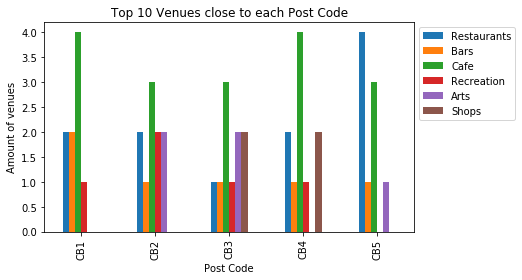

In [179]:
Cam_grouped_df2.plot(x='Area', y=['Restaurants','Bars','Cafe','Recreation','Arts','Shops'], kind='bar')
plt.ylabel('Amount of venues')
plt.xlabel('Post Code')
plt.title("Top 10 Venues close to each Post Code")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))

# Our Findings

Firstly we gathered geospacial data on all the postcodes within the UK, provided by the roayal mail postal service. This data was restructured and used to determine central points for candidate districts within our chosen city. These were filtered down to 5 potential areas and visulised on an interact map. The distance of these locations from the Cities 2 train stations was determined and visulised, both graphically and on an interactive map. 

We then gathered information on reported crimes within the city. The local policeforce provides crime statistics monthly for each county, this also contains location data of the reported crimes. Data was collected from the past 6 months and merged into one workable dataframe. This was further processed to provide information just within our selected areas. This crime data was visulised acording to location and an interactive heatmap was created to demonstrate which areas have the highest concentration of crimes reported.

We then collected information on the local venues within Cambridge using Foursquare API. The differnt establishments were clustered using one hot encoding and K-means analysis and maped to provide visuals for our different clusters. The Venues types were sorted and subgrouped into defined subsets which allowed us to analyse and compare the differnt types of venues within each area. This information was displayed graphically to allow the investeres to determine which types of venue may be most desirable to their targeted demongraphic allowing them to make a more informed choice on which locations may be more appropriate to develop on.

Based on the crimestatistics data the 'safest' location to develop properties would be within either the CB3 or CB2 areas. CB3 is far away from both of the train stations within Cambridge whereas CB2 is very close to the Central station (but far away from Cambridge North train station). When looking at the top 100 venues for each area, CB2 has the highest number of Restaurants and a very high proportion of Cafes. When looking at the closest 10 venues CB2 doesnt have the most of any one venue type, however it does have a good balance of all venue types, except for shops. The data produced from this project suggests CB2 would be one of the best potential development sites for our choosen demographic based on the desirable traits listed at the begining of the project.

## Future analysis

To provide even more detailed analysis on the best potential area to develope further information on the areas should be collected.

Houseing prices within each location could be analysed to provide more benifical information to the developers, as very expensive areas are likly to put off some of their demographic.

The crime data could also be further analysed. The categories of crimes could be divided and clustered into subgroups to help the developers gain an understading of which types of crimes are more common to the areas, for example smaller crimes, such as bicyle theft to more serious crimes such as Assult or violent crimes. 